# 1. Modelado y cuadrados mínimos

En esta primera parte buscamos ajustar un modelo cuadrático de la forma:

$$y = \beta_0 + \beta_1 x + \beta_2 x^2$$

a los datos experimentales:

$$(x_i, y_i) = \{(0,1), (1,2), (2,2.8), (3,3.6), (4,4.5)\}.$$

Para ello representamos el problema en forma matricial y obtenemos las **ecuaciones normales**:

$$A^T A \, \beta = A^T y,$$

que luego resolvemos numéricamente en Python.

## b) Crear una función en Python que resuelva el sistema

En este inciso se implementa una función para resolver el sistema:

$$A^T A \, \beta = A^T y$$

sin utilizar funciones automáticas como `np.linalg.solve` o `np.linalg.lstsq`.
La resolución se realiza mediante el método de **eliminación gaussiana con pivoteo parcial** 
y **sustitución regresiva**, obteniendo los coeficientes del modelo cuadrático $\beta_0, \beta_1, \beta_2$.

In [1]:
import numpy as np

def gaussian_elimination_solve(M, b):
    M = M.astype(float).copy()
    b = b.astype(float).copy()
    n = len(b)

    for k in range(n - 1):
        p = k + np.argmax(np.abs(M[k:, k]))
        if np.isclose(M[p, k], 0.0):
            raise ValueError("Matriz singular o mal condicionada.")
        if p != k:
            M[[k, p]] = M[[p, k]]
            b[[k, p]] = b[[p, k]]
        for i in range(k + 1, n):
            factor = M[i, k] / M[k, k]
            M[i, k:] -= factor * M[k, k:]
            b[i]     -= factor * b[k]

    z = np.zeros(n)
    for i in range(n - 1, -1, -1):
        z[i] = (b[i] - np.dot(M[i, i + 1:], z[i + 1:])) / M[i, i]

    return z

## c) Graficar los datos y la curva ajustada

A partir de los coeficientes obtenidos, la curva ajustada se define como:

$$\hat{y}(x) = \beta_0 + \beta_1 x + \beta_2 x^2.$$

Luego se grafican los puntos originales y la curva estimada, mostrando el ajuste obtenido 
por el método de los mínimos cuadrados.

Coeficientes del modelo: [ 1.03142857  0.91714286 -0.01428571]


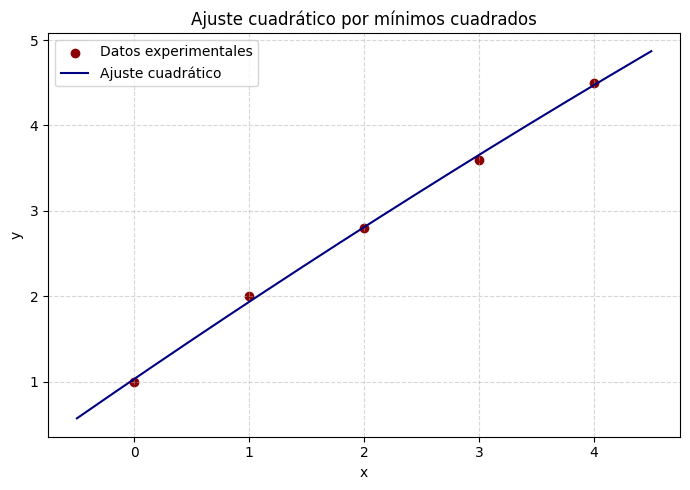

In [2]:
import matplotlib.pyplot as plt

# Datos originales
x = np.array([0, 1, 2, 3, 4], dtype=float)
y = np.array([1, 2, 2.8, 3.6, 4.5], dtype=float)

# Matriz de diseño A y vectores del sistema normal
A = np.vstack([np.ones_like(x), x, x**2]).T
ATA = A.T @ A
ATy = A.T @ y

# Resolución usando la función creada
beta = gaussian_elimination_solve(ATA, ATy)
b0, b1, b2 = beta
print("Coeficientes del modelo:", beta)

# Predicción
xx = np.linspace(x.min()-0.5, x.max()+0.5, 200)
yy = b0 + b1*xx + b2*xx**2

# Gráfico
plt.figure(figsize=(7,5))
plt.scatter(x, y, color='darkred', label='Datos experimentales')
plt.plot(xx, yy, color='navy', label='Ajuste cuadrático')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ajuste cuadrático por mínimos cuadrados")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## d) Error cuadrático medio (MSE)

El error cuadrático medio se calcula como:

$$\mathrm{MSE} = \frac{1}{n}\sum_{i=1}^n \big(y_i - \hat{y}(x_i)\big)^2,$$

donde $\hat{y}(x) = \beta_0 + \beta_1 x + \beta_2 x^2$.

In [3]:
import numpy as np

y_hat = A @ beta
mse = np.mean((y - y_hat) ** 2)

print("MSE =", mse)
print("MSE (8 decimales) =", f"{mse:.8f}")

MSE = 0.0018285714285714183
MSE (8 decimales) = 0.00182857


# 2. Interpretación mediante SVD

En este punto analizamos la matriz de diseño \(A\) mediante su descomposición en valores singulares (SVD):
$$A = U\,\Sigma\,V^{\top},$$
donde \(U\) y \(V\) son matrices ortogonales y \(\Sigma=\operatorname{diag}(\sigma_1,\sigma_2,\sigma_3)\) con \(\sigma_1\ge\sigma_2\ge\sigma_3>0\).

Haremos:
- verificar ortogonalidad de \(U\);
- calcular la solución por SVD: $$\hat\beta_{\text{SVD}}=V\,\Sigma^{-1}U^{\top}y;$$
- comparar con la solución por ecuaciones normales;
- evaluar condicionamiento y colinealidad.

## a) Calcular la SVD de la matriz de diseño A

Obtenemos U, Σ y Vᵀ con `numpy.linalg.svd` y mostramos los valores singulares σᵢ.

In [4]:
import numpy as np

# Datos
x = np.array([0, 1, 2, 3, 4], dtype=float)
y = np.array([1, 2, 2.8, 3.6, 4.5], dtype=float)
A = np.vstack([np.ones_like(x), x, x**2]).T
    
U, S, Vt = np.linalg.svd(A, full_matrices=False)
S

array([19.62153847,  1.86319276,  0.72369934])

## b) Verificar ortogonalidad de U

Comprobamos que:

$$U^{\top} U \approx I$$

In [5]:
I = np.eye(U.shape[1])
ortho_error = np.linalg.norm(U.T @ U - I, ord=np.inf)
ortho_error

np.float64(1.304512053934559e-15)

## c) Comparar β_SVD con ecuaciones normales

Calculamos:

$$\hat{\beta}_{SVD} = V \Sigma^{-1} U^{\top} y$$

y comparamos con la solución anterior midiendo la diferencia:

$$\|\hat{\beta}_{SVD} - \hat{\beta}\|_2$$

In [6]:
V = Vt.T
Sigma_inv = np.diag(1.0 / S)
beta_svd = V @ Sigma_inv @ U.T @ y

ATA = A.T @ A
ATy = A.T @ y

def gaussian_elimination_solve(M, b):
    M = M.astype(float).copy()
    b = b.astype(float).copy()
    n = len(b)
    for k in range(n - 1):
        p = k + np.argmax(np.abs(M[k:, k]))
        if np.isclose(M[p, k], 0.0):
            raise ValueError("Matriz singular o mal condicionada.")
        if p != k:
            M[[k, p]] = M[[p, k]]
            b[[k, p]] = b[[p, k]]
        for i in range(k + 1, n):
            m = M[i, k] / M[k, k]
            M[i, k:] -= m * M[k, k:]
            b[i]     -= m * b[k]
    z = np.zeros(n)
    for i in range(n - 1, -1, -1):
        z[i] = (b[i] - np.dot(M[i, i + 1:], z[i + 1:])) / M[i, i]
    return z

beta_norm = gaussian_elimination_solve(ATA, ATy)

diff_norm = np.linalg.norm(beta_svd - beta_norm)
beta_svd, beta_norm, diff_norm

(array([ 1.03142857,  0.91714286, -0.01428571]),
 array([ 1.03142857,  0.91714286, -0.01428571]),
 np.float64(8.81911577327244e-15))

## d) Condicionamiento y colinealidad

El número de condición de A se calcula como:

$$\kappa_2(A) = \frac{\sigma_{max}}{\sigma_{min}}$$

y analizamos la colinealidad entre columnas usando correlaciones y ángulos.

In [7]:
cond_number = S.max() / S.min()

stds = A.std(axis=0)
mask_var = stds > 1e-12
A_var = A[:, mask_var]

corr = np.corrcoef(A_var.T) if A_var.shape[1] > 1 else np.array([[1.0]])

def angle_deg(u, v, eps=1e-12):
    u = u - u.mean()
    v = v - v.mean()
    nu = np.linalg.norm(u)
    nv = np.linalg.norm(v)
    if nu < eps or nv < eps:
        return np.nan
    cosang = np.clip(np.dot(u, v) / (nu * nv), -1.0, 1.0)
    return np.degrees(np.arccos(cosang))

p = A_var.shape[1]
angles = np.full((p, p), np.nan)
for i in range(p):
    for j in range(p):
        if i != j:
            angles[i, j] = angle_deg(A_var[:, i], A_var[:, j])

cond_number, mask_var, corr, angles

(np.float64(27.112831810234823),
 array([False,  True,  True]),
 array([[1.       , 0.9589266],
        [0.9589266, 1.       ]]),
 array([[        nan, 16.47842727],
        [16.47842727,         nan]]))

# 2. Interpretación mediante SVD

Un sistema se dice mal condicionado cuando pequeñas perturbaciones en A o y provocan grandes variaciones en la solución. Este fenómeno suele deberse a la colinealidad entre las columnas de la matriz de diseño y puede analizarse mediante la descomposición en valores singulares (SVD).

## a) Calcular la SVD de la matriz de diseño A
Obtenemos U, Σ y Vᵀ mediante la función `numpy.linalg.svd` y observamos los valores singulares σᵢ.

In [8]:
import numpy as np

x = np.array([0, 1, 2, 3, 4], dtype=float)
y = np.array([1, 2, 2.8, 3.6, 4.5], dtype=float)
A = np.vstack([np.ones_like(x), x, x**2]).T

U, S, Vt = np.linalg.svd(A, full_matrices=False)
S

array([19.62153847,  1.86319276,  0.72369934])

## b) Verificar ortogonalidad de U

Comprobamos que las columnas de U son ortogonales verificando que:

$$U^{\top}U \approx I$$

In [9]:
I = np.eye(U.shape[1])
ortho_error = np.linalg.norm(U.T @ U - I, ord=np.inf)
ortho_error

np.float64(1.304512053934559e-15)

## c) Comparar la solución obtenida por SVD con la obtenida por ecuaciones normales

Calculamos:

$$\hat{\beta}_{SVD} = V \Sigma^{-1} U^{\top} y$$

y la comparamos con la obtenida mediante ecuaciones normales.

In [10]:
V = Vt.T
Sigma_inv = np.diag(1.0 / S)
beta_svd = V @ Sigma_inv @ U.T @ y

ATA = A.T @ A
ATy = A.T @ y

def gaussian_elimination_solve(M, b):
    M = M.astype(float).copy()
    b = b.astype(float).copy()
    n = len(b)
    for k in range(n - 1):
        p = k + np.argmax(np.abs(M[k:, k]))
        if np.isclose(M[p, k], 0.0):
            raise ValueError("Matriz singular o mal condicionada.")
        if p != k:
            M[[k, p]] = M[[p, k]]
            b[[k, p]] = b[[p, k]]
        for i in range(k + 1, n):
            m = M[i, k] / M[k, k]
            M[i, k:] -= m * M[k, k:]
            b[i]     -= m * b[k]
    z = np.zeros(n)
    for i in range(n - 1, -1, -1):
        z[i] = (b[i] - np.dot(M[i, i + 1:], z[i + 1:])) / M[i, i]
    return z

beta_norm = gaussian_elimination_solve(ATA, ATy)
diff_norm = np.linalg.norm(beta_svd - beta_norm)
beta_svd, beta_norm, diff_norm

(array([ 1.03142857,  0.91714286, -0.01428571]),
 array([ 1.03142857,  0.91714286, -0.01428571]),
 np.float64(8.81911577327244e-15))

## d) Analizar el efecto del mal condicionamiento y la colinealidad entre columnas

Calculamos el número de condición:

$$\kappa_2(A) = \frac{\sigma_{max}}{\sigma_{min}}$$

y analizamos la correlación y el ángulo entre las columnas con varianza no nula.

In [11]:
cond_number = S.max() / S.min()

stds = A.std(axis=0)
mask_var = stds > 1e-12
A_var = A[:, mask_var]

corr = np.corrcoef(A_var.T) if A_var.shape[1] > 1 else np.array([[1.0]])

def angle_deg(u, v, eps=1e-12):
    u = u - u.mean()
    v = v - v.mean()
    nu = np.linalg.norm(u)
    nv = np.linalg.norm(v)
    if nu < eps or nv < eps:
        return np.nan
    cosang = np.clip(np.dot(u, v) / (nu * nv), -1.0, 1.0)
    return np.degrees(np.arccos(cosang))

p = A_var.shape[1]
angles = np.full((p, p), np.nan)
for i in range(p):
    for j in range(p):
        if i != j:
            angles[i, j] = angle_deg(A_var[:, i], A_var[:, j])

cond_number, corr, angles

(np.float64(27.112831810234823),
 array([[1.       , 0.9589266],
        [0.9589266, 1.       ]]),
 array([[        nan, 16.47842727],
        [16.47842727,         nan]]))

# 3. Análisis cuadrático del error

La función de error del modelo se define como

$$Q(\beta) = \|A\beta - y\|^2,$$

y puede escribirse como la forma cuadrática:

$$
Q(\beta) =
\beta^{\top}(A^{\top}A)\beta
- 2(A^{\top}y)^{\top}\beta
+ y^{\top}y.
$$

- Término cuadrático:  
  $$\beta^{\top}(A^{\top}A)\beta$$

- Término lineal:  
  $$2(A^{\top}y)^{\top}\beta$$

- Término independiente:  
  $$y^{\top}y$$

La convexidad de la función se verifica mediante su Hessiana:

$$\nabla^2 Q(\beta) = 2 A^{\top} A.$$

Como $A^{\top}A$ es simétrica y semidefinida positiva, $Q(\beta)$ es convexa y su mínimo global coincide con la solución de mínimos cuadrados:

$$A^{\top}A\,\hat{\beta} = A^{\top}y.$$

## 3.a Visualización de $Q(\beta_1,\beta_2)$

Para visualizar la geometría de la función de error, fijamos el valor óptimo de $\beta_0$ y evaluamos

$$Q(\beta_1,\beta_2)$$

sobre una grilla en el plano $(\beta_1,\beta_2)$.
Las curvas de nivel muestran el paraboloide convexo asociado al error y el mínimo global correspondiente a $\hat{\beta}$.

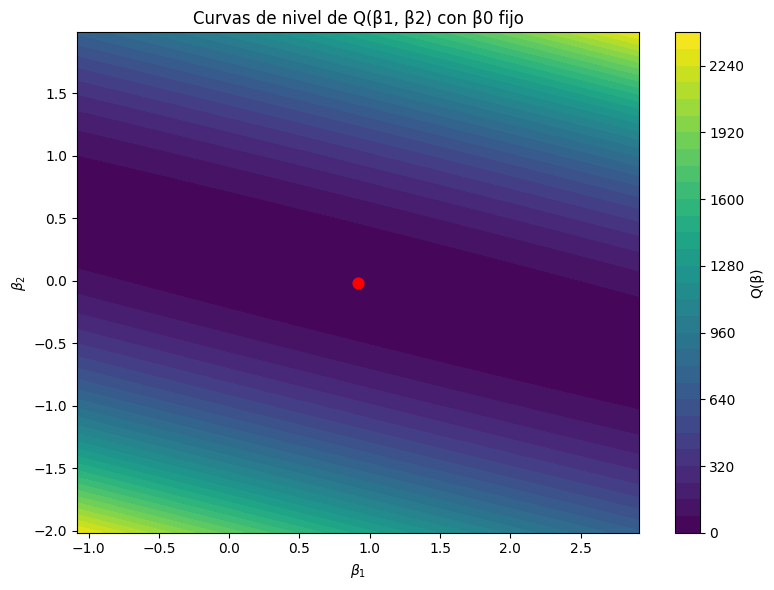

In [12]:
import numpy as np
import matplotlib.pyplot as plt

beta_hat = beta
beta0_fijo = beta_hat[0]

b1_vals = np.linspace(beta_hat[1] - 2, beta_hat[1] + 2, 150)
b2_vals = np.linspace(beta_hat[2] - 2, beta_hat[2] + 2, 150)

B1, B2 = np.meshgrid(b1_vals, b2_vals)
Q_vals = np.zeros_like(B1)

for i in range(B1.shape[0]):
    for j in range(B1.shape[1]):
        beta_tmp = np.array([beta0_fijo, B1[i,j], B2[i,j]])
        resid = A @ beta_tmp - y
        Q_vals[i,j] = resid @ resid

plt.figure(figsize=(8,6))
cont = plt.contourf(B1, B2, Q_vals, levels=30, cmap="viridis")
plt.colorbar(cont, label="Q(β)")
plt.scatter(beta_hat[1], beta_hat[2], c="red", s=60)
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.title("Curvas de nivel de Q(β1, β2) con β0 fijo")
plt.tight_layout()
plt.show()


## 3.b Convexidad de $Q(\beta)$ y mínimo de mínimos cuadrados

La función de error del modelo puede escribirse como

$$
Q(\beta) = \|A\beta - y\|^2
          = \beta^{\top}(A^{\top}A)\beta
          - 2 (A^{\top}y)^{\top}\beta
          + y^{\top}y.
$$

Su gradiente y su Hessiana son

$$
\nabla Q(\beta) = 2A^{\top}(A\beta - y),
\qquad
\nabla^2 Q(\beta) = 2A^{\top}A.
$$

Como $A^{\top}A$ es simétrica y semidefinida positiva, $\nabla^2 Q(\beta)$ es positiva semidefinida
y por lo tanto $Q(\beta)$ es una función convexa.

El mínimo global se alcanza cuando el gradiente se anula:

$$
\nabla Q(\beta) = 0
\;\Longrightarrow\;
A^{\top}A\,\hat\beta = A^{\top}y.
$$

A continuación verificamos numéricamente estos hechos calculando los autovalores de la Hessiana
y el gradiente en $\hat\beta$.

In [13]:
H = 2 * (A.T @ A)
eigvals = np.linalg.eigvals(H)

grad_beta_hat = 2 * A.T @ (A @ beta_hat - y)

eigvals, grad_beta_hat


(array([770.00954402,   6.94297451,   1.04748147]),
 array([-4.88498131e-15, -5.32907052e-15,  3.90798505e-14]))

# 4. Optimización numérica: descenso por gradiente

En esta sección implementamos el método de descenso por gradiente para minimizar la función

$$Q(\beta)=\|A\beta - y\|^2,$$

cuya derivada viene dada por

$$\nabla Q(\beta)=2A^{\top}(A\beta - y).$$

Partimos de un valor inicial $\beta^{(0)}$ y actualizamos iterativamente:

$$
\beta^{(k+1)} = \beta^{(k)} - \eta \, \nabla Q(\beta^{(k)})
$$

donde $\eta > 0$ es la tasa de aprendizaje.

El algoritmo se detiene cuando la norma del gradiente es suficientemente pequeña o cuando se alcanza un número máximo de iteraciones.

## 4.a Implementación del método

A continuación implementamos el método de descenso por gradiente para la función $Q(\beta)$.

In [14]:
import numpy as np

def gradient_descent_Q(A, y, beta0, lr=1e-3, tol=1e-8, max_iter=100000):
    beta = beta0.astype(float).copy()
    grad_norm_history = []

    for k in range(max_iter):
        grad = 2 * A.T @ (A @ beta - y)
        grad_norm = np.linalg.norm(grad)
        grad_norm_history.append(grad_norm)

        if grad_norm < tol:
            break

        beta = beta - lr * grad

    return beta, np.array(grad_norm_history), k + 1


### 4.b Experimentos con tasas de aprendizaje y tolerancias

El comportamiento del descenso por gradiente depende fuertemente de la **tasa de aprendizaje** $\eta$ 
y de la **tolerancia** del criterio de corte.

Si $\eta$ es demasiado pequeña, el método converge pero lo hace muy lento;  
si $\eta$ es demasiado grande, las iteraciones pueden oscilar o incluso divergir.  
Por otro lado, tolerancias más exigentes (por ejemplo, $10^{-8}$ en lugar de $10^{-4}$) 
requieren más iteraciones pero producen soluciones más cercanas a $\hat{\beta}$.

A continuación comparamos el método para distintos valores de $\eta$ y $\text{tol}$, 
registrando:
- la cantidad de iteraciones,
- la norma del gradiente final,
- y la distancia $\|\beta_{\text{GD}} - \hat{\beta}\|_2$ respecto de la solución de mínimos cuadrados.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2791: RuntimeWarning: overflow encountered in dot
  sqnorm = x.dot(x)
/var/folders/w2/ddmn21_s0j5g5k_ptkssbfp40000gn/T/ipykernel_70349/302014083.py:8: RuntimeWarning: overflow encountered in matmul
  grad = 2 * A.T @ (A @ beta - y)
/var/folders/w2/ddmn21_s0j5g5k_ptkssbfp40000gn/T/ipykernel_70349/302014083.py:8: RuntimeWarning: invalid value encountered in matmul
  grad = 2 * A.T @ (A @ beta - y)


lr		 tol		 iters	 grad_final		 ||beta_gd - beta_hat||
1e-04	 1e-04	  65028	 9.999e-05	 9.546e-05
1e-04	 1e-06	 100000	 2.564e-06	 2.448e-06
1e-04	 1e-08	 100000	 2.564e-06	 2.448e-06
1e-03	 1e-04	   6501	 9.995e-05	 9.542e-05
1e-03	 1e-06	  10895	 9.997e-07	 9.543e-07
1e-03	 1e-08	  15289	 9.998e-09	 9.545e-09
5e-03	 1e-04	 100000	 nan	 nan
5e-03	 1e-06	 100000	 nan	 nan
5e-03	 1e-08	 100000	 nan	 nan
1e-02	 1e-04	 100000	 nan	 nan
1e-02	 1e-06	 100000	 nan	 nan
1e-02	 1e-08	 100000	 nan	 nan


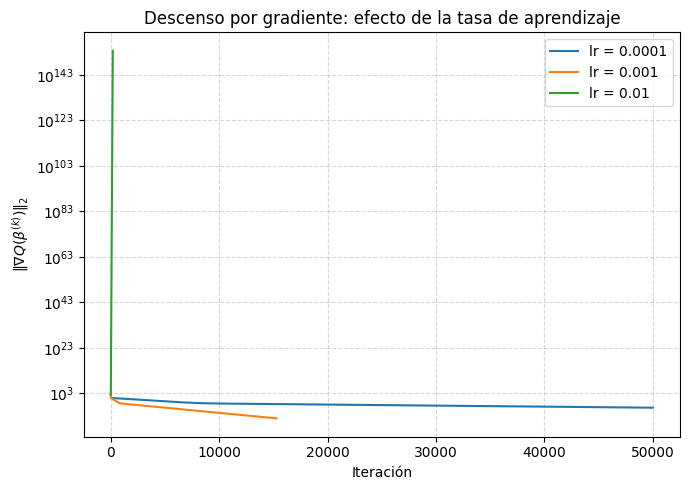

In [15]:
lrs = [1e-4, 1e-3, 5e-3, 1e-2]
tols = [1e-4, 1e-6, 1e-8]

resultados = []

for lr in lrs:
    for tol in tols:
        beta0 = np.zeros_like(beta_hat)
        beta_gd, grad_hist, iters = gradient_descent_Q(
            A, y, beta0,
            lr=lr,
            tol=tol,
            max_iter=100000
        )
        dist = np.linalg.norm(beta_gd - beta_hat)
        grad_final = grad_hist[-1]
        resultados.append((lr, tol, iters, grad_final, dist))

print("lr\t\t tol\t\t iters\t grad_final\t\t ||beta_gd - beta_hat||")
for lr, tol, iters, grad_final, dist in resultados:
    print(f"{lr:.0e}\t {tol:.0e}\t {iters:6d}\t {grad_final:.3e}\t {dist:.3e}")

plt.figure(figsize=(7,5))
for lr in [1e-4, 1e-3, 1e-2]:
    beta0 = np.zeros_like(beta_hat)
    beta_gd, grad_hist, iters = gradient_descent_Q(
        A, y, beta0,
        lr=lr,
        tol=1e-8,
        max_iter=50000
    )
    plt.semilogy(grad_hist, label=f"lr = {lr}")

plt.xlabel("Iteración")
plt.ylabel(r"$\|\nabla Q(\beta^{(k)})\|_2$")
plt.title("Descenso por gradiente: efecto de la tasa de aprendizaje")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 5. Discusión y extensiones

En este punto comparamos los métodos utilizados (ecuaciones normales, SVD y descenso por gradiente) y analizamos cómo cambia el ajuste al incorporar un término cúbico o ruido en los datos.

## a) Relación entre los distintos métodos

En este trabajo utilizamos tres enfoques para resolver el problema de mínimos cuadrados:

1. **Ecuaciones normales**  
   Resuelven directamente el sistema
   $$A^{\top} A \, \beta = A^{\top} y.$$
   Es un método sencillo, pero puede ser sensible al mal condicionamiento de \(A^{\top}A\).

2. **Descomposición SVD**  
   Escribimos
   $$A = U \Sigma V^{\top},$$
   y obtenemos
   $$\hat{\beta}_{SVD} = V \Sigma^{-1} U^{\top} y.$$
   Es más estable numéricamente y permite analizar el condicionamiento a partir de los valores singulares.

3. **Descenso por gradiente**  
   Minimiza iterativamente
   $$Q(\beta) = \|A \beta - y\|^2$$
   mediante actualizaciones del tipo
   $$\beta_{k+1} = \beta_k - \eta \nabla Q(\beta_k).$$
  Es útil cuando la dimensión del problema crece o cuando no conviene formar explícitamente  
$$A^{\top} A.$$

En este problema particular, los tres métodos convergen a la misma solución de mínimos cuadrados; las diferencias se observan en estabilidad numérica, número de iteraciones y facilidad de implementación.

## b) Modelo cúbico y efecto del ruido

Extendemos el modelo incluyendo un término cúbico:

$$y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3,$$

y luego añadimos ruido aleatorio a los datos originales para observar cómo cambian el ajuste y el error cuadrático medio (MSE).

In [16]:
import numpy as np

x = np.array([0, 1, 2, 3, 4], dtype=float)
y = np.array([1, 2, 2.8, 3.6, 4.5], dtype=float)

A_quad = np.vstack([np.ones_like(x), x, x**2]).T
A_cubic = np.vstack([np.ones_like(x), x, x**2, x**3]).T

ATA_quad = A_quad.T @ A_quad
ATy_quad = A_quad.T @ y
ATA_cubic = A_cubic.T @ A_cubic
ATy_cubic = A_cubic.T @ y

beta_quad = gaussian_elimination_solve(ATA_quad, ATy_quad)
beta_cubic = gaussian_elimination_solve(ATA_cubic, ATy_cubic)

x_plot = np.linspace(x.min()-0.5, x.max()+0.5, 200)
y_hat_quad = beta_quad[0] + beta_quad[1]*x_plot + beta_quad[2]*x_plot**2
y_hat_cubic = (beta_cubic[0]
               + beta_cubic[1]*x_plot
               + beta_cubic[2]*x_plot**2
               + beta_cubic[3]*x_plot**3)

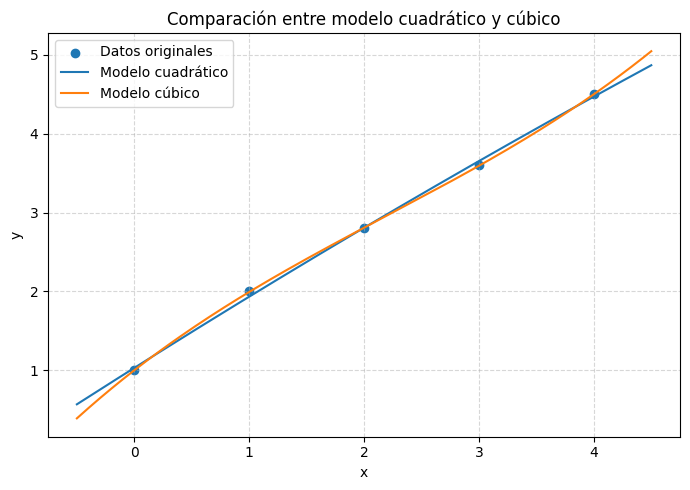

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(x, y, label="Datos originales")
plt.plot(x_plot, y_hat_quad, label="Modelo cuadrático")
plt.plot(x_plot, y_hat_cubic, label="Modelo cúbico")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Comparación entre modelo cuadrático y cúbico")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [18]:
rng = np.random.default_rng(0)
noise = rng.normal(loc=0.0, scale=0.1, size=x.shape)
y_noisy = y + noise

ATy_quad_noisy = A_quad.T @ y_noisy
beta_quad_noisy = gaussian_elimination_solve(ATA_quad, ATy_quad_noisy)

y_hat_quad_clean = A_quad @ beta_quad
y_hat_quad_noisy = A_quad @ beta_quad_noisy

mse_clean = np.mean((y - y_hat_quad_clean)**2)
mse_noisy = np.mean((y_noisy - y_hat_quad_noisy)**2)

mse_clean, mse_noisy

(np.float64(0.0018285714285714183), np.float64(0.0008798764750914796))

## 6. Aplicación a un caso real

En esta sección aplicamos los conceptos desarrollados a un conjunto de datos reales.  
El objetivo es construir un modelo predictivo que relacione el salario de una persona
con su experiencia laboral, utilizando herramientas de ajuste por mínimos cuadrados,
análisis matricial y SVD.

Trabajamos con el dataset **Salary Data**, que contiene, entre otros campos:

- `Years of Experience`: años de experiencia laboral.
- `Salary`: salario anual asociado.

Formulamos el problema en términos matriciales, identificando la variable objetivo
\(y\) y la matriz de diseño \(A\), resolvemos el modelo por ecuaciones normales y por SVD,
evaluamos la calidad del ajuste y visualizamos la recta obtenida.

### a) Cargar el dataset

Cargamos el dataset `Salary Data.csv` y observamos sus primeras filas para identificar
la variable objetivo \(y\) y los posibles predictores.

In [19]:
import pandas as pd
import numpy as np

df = pd.read_csv("Salary Data.csv")
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


### b) Construcción de la matriz de diseño

Tomamos como variable objetivo

- $y = \texttt{Salary}$

y como predictor principal

- $x = \texttt{Years of Experience}$.

Primero nos quedamos solo con estas dos columnas, convertimos a valores numéricos
y eliminamos filas con datos faltantes. Luego construimos la matriz de diseño

$$
A =
\begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_n
\end{bmatrix},
$$

donde la primera columna es el término independiente del modelo lineal.

In [20]:
cols = ["Years of Experience", "Salary"]
df_num = df[cols].apply(pd.to_numeric, errors="coerce").dropna()

X = df_num[["Years of Experience"]].to_numpy()
y = df_num["Salary"].to_numpy()

A = np.hstack([np.ones((X.shape[0], 1)), X])
A.shape, y.shape

((373, 2), (373,))

### c) Resolver el modelo por ecuaciones normales

Calculamos la solución de mínimos cuadrados resolviendo el sistema de ecuaciones normales:

$$A^{\top}A\,\hat\beta = A^{\top}y.$$

Denotamos la solución obtenida por este método como $\hat\beta_{\text{norm}}$,  
que contiene el término independiente y la pendiente del modelo lineal.

In [21]:
ATA = A.T @ A
ATy = A.T @ y

beta_norm = gaussian_elimination_solve(ATA, ATy)
beta_norm

array([31921.21691704,  6844.51051448])

### d) Resolver el modelo mediante SVD

También podemos obtener la solución de mínimos cuadrados mediante la descomposición en valores singulares (SVD) de la matriz de diseño:

$$A = U\,\Sigma\,V^{\top},$$

lo que lleva a la solución

$$\hat\beta_{\text{SVD}} = V\,\Sigma^{-1}\,U^{\top}y.$$

Luego comparamos $\hat\beta_{\text{SVD}}$ con $\hat\beta_{\text{norm}}$ midiendo la norma de su diferencia.

In [22]:
U, S, Vt = np.linalg.svd(A, full_matrices=False)
Sigma_inv = np.diag(1 / S)

beta_svd = Vt.T @ Sigma_inv @ U.T @ y

np.linalg.norm(beta_svd - beta_norm)

np.float64(6.208592154826333e-11)

### e) Evaluación del modelo

Con los coeficientes obtenidos por ecuaciones normales, calculamos las predicciones

$$\hat y = A\,\hat\beta_{\text{norm}},$$

y evaluamos la calidad del ajuste mediante el **error cuadrático medio (MSE)**:

$$\mathrm{MSE} = \frac{1}{n}\sum_{i=1}^n (y_i - \hat y_i)^2.$$

In [23]:
y_hat = A @ beta_norm
mse = np.mean((y - y_hat) ** 2)
mse

np.float64(312090043.79900104)

### f) Visualización del ajuste

Por último, graficamos los datos reales $(x_i, y_i)$ junto con la recta ajustada:

$$\hat y(x) = \hat\beta_0 + \hat\beta_1\,x,$$

para visualizar cómo se adapta el modelo lineal al conjunto de datos.

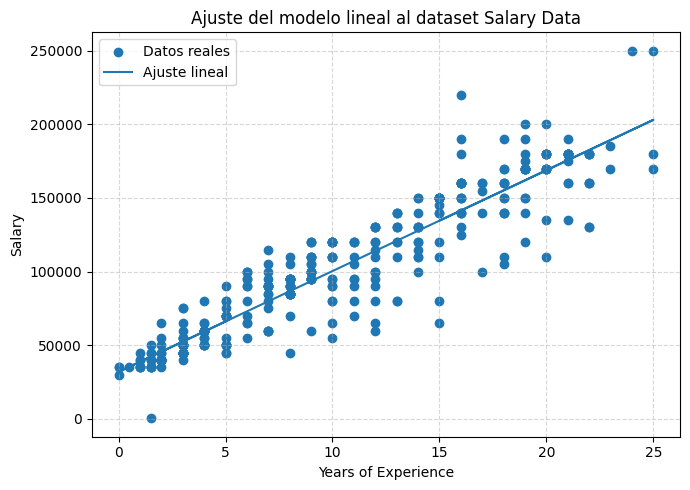

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(X, y, label="Datos reales")
plt.plot(X, y_hat, label="Ajuste lineal")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.title("Ajuste del modelo lineal al dataset Salary Data")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()